# Project 2: Ames Housing Data and Kaggle Challenge

## Part II - Modeling

Author: Charles Ramey

Date: 03/19/2023

---

#### Links

For the second and third iterations, see the following notebooks:
- [`Part-2.2_model-iteration-2.ipynb`](../code/Part-2.2_model-iteration-2.ipynb)
- [`Part-2.3_model-iteration-3.ipynb`](../code/Part-2.3_model-iteration-3.ipynb)

To see the conclusions and recommendations of this project, see the following notebook:
- [`Part-3_conclusion-and-recommendations.ipynb`](../code/Part-3_conclusion-and-recommendations.ipynb)

### Contents

- [Preprocessing](#Preprocessing)
- [Linear Model](#Linear-Model)
- [Ridge Model](#Ridge-Model)
- [Lasso Model](#Lasso-Model)
- [ElasticNet Model](#ElasticNet-Model)
- [Predictions](#Predictions)

## Model Iteration 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

import warnings

In [2]:
df_train = pd.read_csv('../datasets/train_cleaned.csv')
df_test = pd.read_csv('../datasets/test_cleaned.csv')
df_train.head()

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,44,0,0,0,0,0,3,2010,WD,130500
1,544,531379050,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,74,0,0,0,0,0,4,2009,WD,220000
2,153,535304180,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,...,52,0,0,0,0,0,1,2010,WD,109000
3,318,916386060,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,4,2010,WD,174000
4,255,906425045,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,...,59,0,0,0,0,0,3,2010,WD,138500


### Preprocessing & Feature Engineering

In [3]:
X = df_train[['id','lot_area','overall_qual','overall_cond','1st_flr_sf','2nd_flr_sf']]
y = df_train['saleprice']

df_test = df_test[['id','lot_area','overall_qual','overall_cond','1st_flr_sf','2nd_flr_sf']]

In [4]:
# The portion of the training data that is being split for model validation is 
# defined as X_val and y_val to avoid confusion with the test dataset.
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 5)

In [5]:
X_train.shape, X_val.shape, df_test.shape

((1640, 6), (411, 6), (878, 6))

In [6]:
tr_id = X_train['id']
val_id = X_val['id']

In [7]:
poly = PolynomialFeatures(
    degree = 2,
    interaction_only= True,
    include_bias=False)

In [8]:
X_train = poly.fit_transform(
    X_train.drop(columns = 'id'))

X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())

X_val = pd.DataFrame(
    poly.transform(X_val.drop(columns = 'id')),
    columns = poly.get_feature_names_out())

In [9]:
X_train.shape, X_val.shape

((1640, 15), (411, 15))

In [10]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())

Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

In [11]:
def model_outputs(model, Xs_train, Xs_val, y_train, y_val):
    results_dict = {'Training score': model.score(Xs_train, y_train),
    'Testing score': model.score(Xs_val, y_val),
    'Training cross-validation score': cross_val_score(model, Xs_train, y_train, cv=5).mean(),
    'Testing cross-validation score': cross_val_score(model, Xs_val, y_val, cv=5).mean(),
    'Training RMSE score': mean_squared_error(y_train, model.predict(Xs_train), squared = False),
    'Testing RMSE score': mean_squared_error(y_val, model.predict(Xs_val), squared = False)
    }
    
    return pd.DataFrame.from_dict(results_dict, orient = 'index', columns = ['score'])

### Baseline and Linear Models

In [12]:
lr = LinearRegression()

lr.fit(Xs_train, y_train)

LinearRegression()

#### Baseline Model

To get a baseline to compare our models in this iteration to, we'll use a linear model to predict the mean of the training data sale price and then score it.

In [13]:
y_train.mean()

179677.99207317072

In [14]:
y_base = np.array([np.mean(y_train)] * len(y_train)).reshape(-1, 1)
print(f"Baseline score: {lr.score(Xs_train, y_base)}")

Baseline score: -1.534191929274969e+30


As you can see, the baseline model does not perform well...

#### Linear Model

In [15]:
model_outputs(lr, Xs_train, Xs_val, y_train, y_val)

,score
Training score,0.841787
Testing score,0.753762
Training cross-validation score,0.800297
Testing cross-validation score,0.803884
Training RMSE score,31256.524697
Testing RMSE score,40402.962907


Using the linear regression model, 84% of the variability in the price of the training data is explained by the features used in this iteration. The model has mild bias and does not generalize well, as the testing data scored 10% lower than the training data. The root mean squared error (RMSE) indicates that the model is likely to predict sale prices that are approximately $31,000-41,000 off of the true price.

''

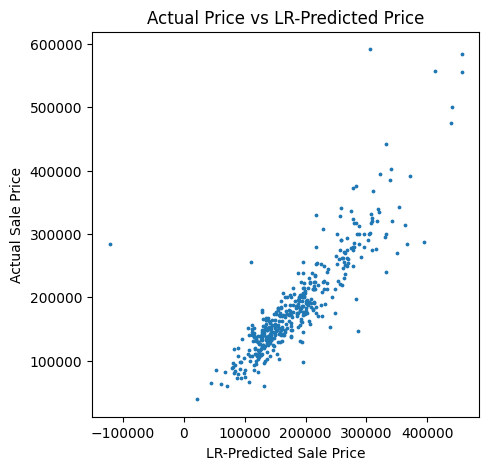

In [16]:
lr_pred = lr.predict(Xs_val)

lr_resid = y_val - lr_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(lr_pred, y_val, s=3)
ax.set_title('Actual Price vs LR-Predicted Price')
ax.set_xlabel('LR-Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

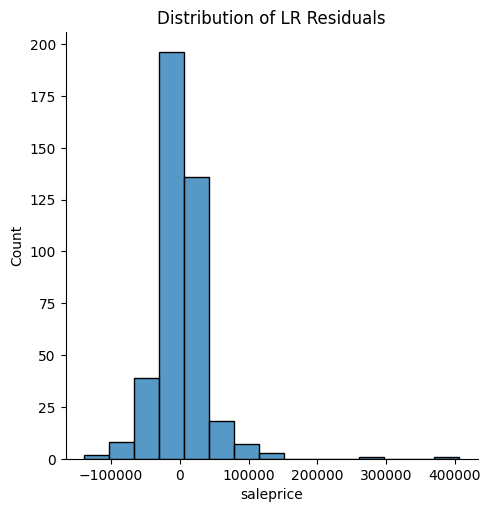

In [17]:
sns.displot(data=lr_resid, bins=15).set(title='Distribution of LR Residuals');

### Ridge Model

In [18]:
ridge = RidgeCV(alphas = np.logspace(0,5, 100))

In [19]:
ridge.fit(Xs_train, y_train);

In [20]:
model_outputs(ridge, Xs_train, Xs_val, y_train, y_val)

,score
Training score,0.840648
Testing score,0.763939
Training cross-validation score,0.779031
Testing cross-validation score,0.817428
Training RMSE score,31368.797036
Testing RMSE score,39559.241008


The Ridge model appears to perform similar to the linear model, if not slightly worse. The model has higher bias and also does not generalize well. The model received a 5-fold cross-validation score of 78% on the training data, compared to 82% on the testing data.

In [21]:
ridge.alpha_

4.0370172585965545

''

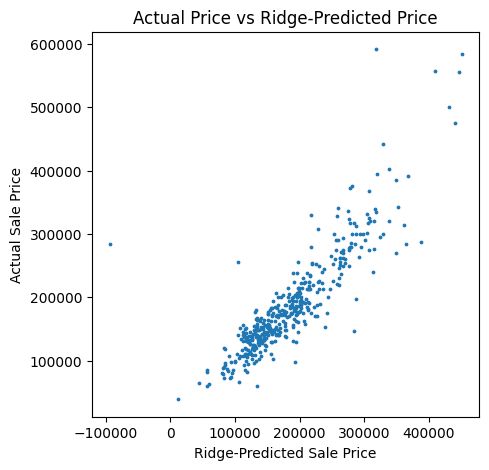

In [22]:
ridge_pred = ridge.predict(Xs_val)

ridge_resid = y_val - ridge_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(ridge_pred, y_val, s=3)
ax.set_title('Actual Price vs Ridge-Predicted Price')
ax.set_xlabel('Ridge-Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

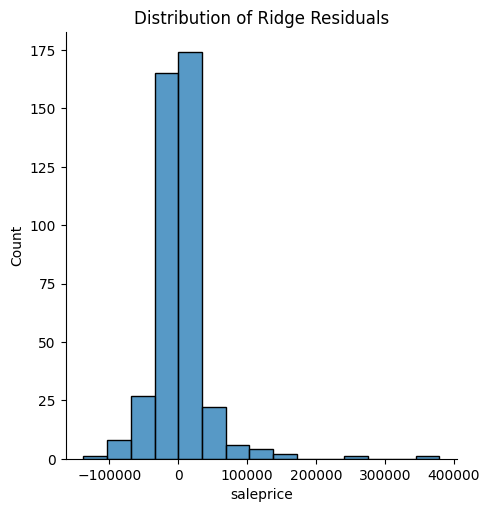

In [23]:
sns.displot(data=ridge_resid, bins=15).set(title='Distribution of Ridge Residuals');

### Lasso Model

In [24]:
lasso = LassoCV(alphas = np.arange(0.001, 10, 1))

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lasso.fit(Xs_train, y_train)

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(model_outputs(lasso, Xs_train, Xs_val, y_train, y_val))

                                        score
Training score                       0.841763
Testing score                        0.753930
Training cross-validation score      0.800087
Testing cross-validation score       0.805636
Training RMSE score              31258.836945
Testing RMSE score               40389.186546


The Lasso model, relative to the Ridge model, appears to generalize better, acheiving nearly identical 5-fold cross-validation scores on the training data and the testing data (80% and 81%, respectively.) However, the RMSE indicates that the Lasso model may be less accurate overall compared to the Ridge model.

In [27]:
lasso.alpha_

9.000999999999998

In [28]:
lasso_2 = LassoCV(alphas = np.arange(8, 10, 0.1))

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lasso_2.fit(Xs_train, y_train)

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(model_outputs(lasso_2, Xs_train, Xs_val, y_train, y_val))

                                        score
Training score                       0.841758
Testing score                        0.753944
Training cross-validation score      0.800330
Testing cross-validation score       0.805780
Training RMSE score              31259.319875
Testing RMSE score               40388.034996


In [31]:
lasso_2.alpha_

9.899999999999993

''

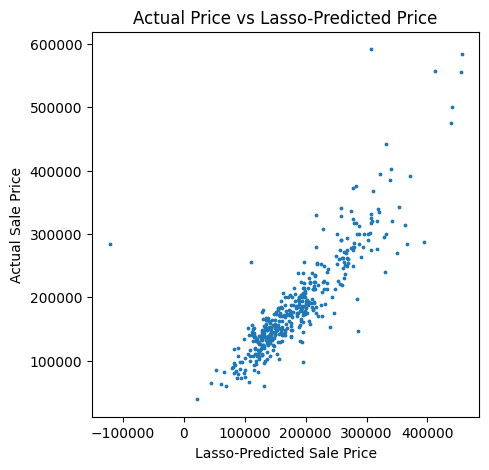

In [32]:
lasso_pred = lasso.predict(Xs_val)

lasso_resid = y_val - lasso_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(lasso_pred, y_val, s=3)
ax.set_title('Actual Price vs Lasso-Predicted Price')
ax.set_xlabel('Lasso-Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

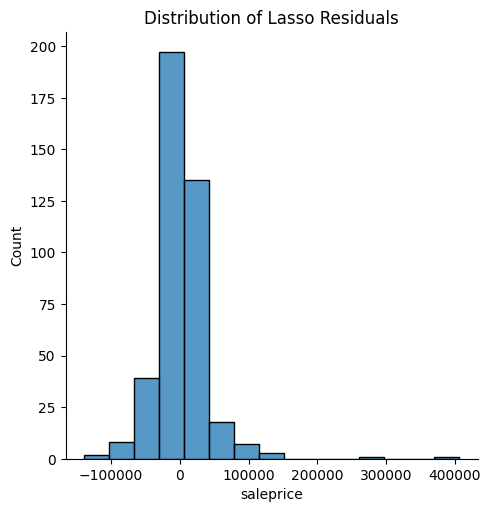

In [33]:
sns.displot(data=lasso_resid, bins=15).set(title='Distribution of Lasso Residuals');

### ElasticNet Model

In [34]:
enet_params = {
    'l1_ratio':[0.3, 0.4, 0.5, 0.6, 0.7],
    'alpha': list(np.arange(0.001, 0.01, 0.001))
}

In [35]:
enet_gridsearcher = GridSearchCV(
    ElasticNet(),
    enet_params,
    cv = 5,
    verbose=1)

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    enet_gridsearcher.fit(Xs_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [37]:
enet_gridsearcher.best_params_

{'alpha': 0.007, 'l1_ratio': 0.3}

In [38]:
enet = ElasticNetCV(
    l1_ratio=0.3, 
    alphas = np.arange(0.006, 0.01, 0.001))

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    enet.fit(Xs_train, y_train)

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(model_outputs(enet, Xs_train, Xs_val, y_train, y_val))

                                        score
Training score                       0.839362
Testing score                        0.769018
Training cross-validation score      0.802593
Testing cross-validation score       0.817772
Training RMSE score              31495.118335
Testing RMSE score               39131.381113


Using gridsearch to optimize the hyperparameters of the ElasticNet model, this model performed similarly to the others above. While the expecation was that the ElasticNet model would outperform the others, the model did not appear to distinguish itself.

In [41]:
enet.alpha_

0.006

''

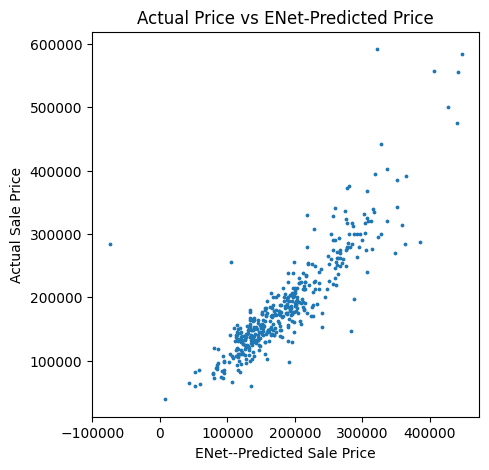

In [42]:
enet_pred = enet.predict(Xs_val)

enet_resid = y_val - enet_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(enet_pred, y_val, s=3)
ax.set_title('Actual Price vs ENet-Predicted Price')
ax.set_xlabel('ENet--Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

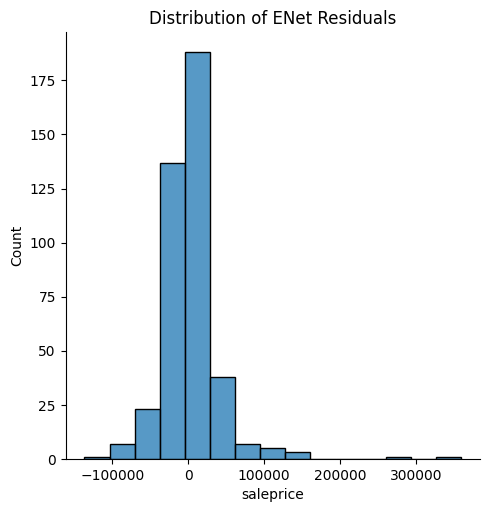

In [43]:
sns.displot(data=enet_resid, bins=15).set(title='Distribution of ENet Residuals');

### Predictions

In [44]:
df_test.head(1)

,id,lot_area,overall_qual,overall_cond,1st_flr_sf,2nd_flr_sf
0,2658,9142,6,8,908,1020


In [45]:
test_id = df_test['id']

In [46]:
df_test = poly.transform(df_test.drop(columns ='id'))

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # preprocessed with standard scalar
    Xs_test = pd.DataFrame(
        ss.transform(df_test),
        columns = poly.get_feature_names_out()
    )

In [48]:
ridge_sub = Ridge(alpha = ridge.alpha_)

In [49]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #fit
    ridge_sub.fit(Xs_train, y_train)

In [50]:
preds = ridge_sub.predict(Xs_test)

In [51]:
preds = pd.DataFrame({'Id': test_id, 'Saleprice': preds})

In [52]:
preds.head()

,Id,Saleprice
0,2658,184409.961589
1,2718,175081.141693
2,2414,222406.040267
3,1989,122363.495452
4,625,177160.072088


In [53]:
preds.to_csv('../prediction_results/ridge_1_simple.csv', index=False)